# Entrainement du modèle LDA pour l'univers Fixe : A la recherche du meilleur modèle

## - Installation des dépendances

In [4]:
!pip install numpy scipy
!pip install gensim # For topic modeling
# Install NLTK and download relevant resources if you haven't done so already
!pip install nltk
# install spacy
!pip install -U spacy
!pip install pyLDAvis # For visualizing topic models
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 33.5 MB/s eta 0:00:00
  Attempting unin

In [1]:
!pip install --upgrade pyLDAvis gensim pandas

In [ ]:
!pip install spacy-lefff

In [ ]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

## - Prétraitement des données des descriptions des appels des clients 

In [ ]:
#test
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
# import openpyxl
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer  # Ajoutez cette ligne
import re
import spacy
from spacy_lefff import LefffLemmatizer
from spacy.language import Language
# from autocorrect import Speller
# spell = Speller(lang='fr')

In [ ]:
import spacy
from spacy_lefff import LefffLemmatizer
from spacy.language import Language

@Language.factory('french_lemmatizer')
def create_french_lemmatizer(nlp, name):
    return LefffLemmatizer()

nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('french_lemmatizer', name='lefff')

In [ ]:
!pip install unidecode

In [ ]:
from unidecode import unidecode

def normalize_text(text):
    return unidecode(text)

In [ ]:
# Define a list of patterns to search for and their corresponding replacement
pattern_replacements = [
    (r'\bpositionn\b', 'positionner'),
    (r'\brechargemer\b', 'rechargement'),
    (r'\bbloqu\b', 'bloque'),
    (r'\brechar\b', 'retrait'),
    (r'\bretraire\b', 'retrait'),
    (r'\bstart\b', 'star'),
    (r'\bsouscrir\b', 'souscription'),
    (r'\bsauvegard\b', 'sauvegarde'),
    (r'\brepertoir\b', 'repertoire'),
    (r'\brecu\b', 'reçu'),
    (r'\bperdre\b', 'perdu'),  # Replace "perdre" with "perdu"
    (r'\bcas\b', 'case'),
    (r'\bpas\b', 'pass'),
    (r'\bsouscrir\b', 'souscription'),
    (r'\billimi\b', 'illimix'),
    (r'\bperte\b', 'perdu'),   # Replace "perte" with "perdu"
    (r'\bperdre\u00A0', 'perdu'),  # Replace "perdre" with "perdu"
    (r'\bperte\u00A0', 'perdu'),   # Replace "perte" with "perdu"
    # Add more patterns as needed
]

def merge_similar_phrases(text):
    for pattern, replacement in pattern_replacements:
        text = re.sub(pattern, replacement, text)
    return text

# Function to post-process text
def post_process_creditperdu(text):
    # Define a pattern to match consecutive occurrences of "crédit perdu"
    pattern = r'\b(credit perdu)(?:\s+\1)+\b'

    # Replace consecutive occurrences with "crédit perdu (xN)"
    def replace(match):
        num_occurrences = match.group().count('credit perdu') + 1
        return f'credit perdu (x{num_occurrences})'

    text = re.sub(pattern, replace, text)

    return text

def post_process_casecreation(text):
    # Define a pattern to match consecutive occurrences of "crédit perdu"
    pattern = r'\b(creation case)(?:\s+\1)+\b'

    # Replace consecutive occurrences with "crédit perdu (xN)"
    def replace(match):
        num_occurrences = match.group().count('creation case') + 1
        return f'creation case (x{num_occurrences})'

    text = re.sub(pattern, replace, text)

    return text

In [ ]:
# Chargement des stopwords français
with open("/content/frenchStopwords.txt", 'r', encoding='utf-8') as file:
    frenchStopwords = file.read().split('\n')

# Combinaison des stopwords français avec les stopwords NLTK
nltk.download('stopwords')
stopwords = frenchStopwords + stopwords.words('french')

# Fonction de prétraitement des descriptions
def preprocess(document):
    words = word_tokenize(re.sub(r"\b(?:[a-zA-Z])\'\b", '', document.lower()))  # Tokenization et mise en minuscules
    words = [normalize_text(word) for word in words if word.isalpha() and word not in stopwords]
    doc = nlp(" ".join( words))
    # lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization avec WordNetLemmatizer
    lemmatized_words = [token.lemma_ for token in doc ]
    cleanedtext = " ".join(lemmatized_words)
    cleanedtext = merge_similar_phrases(cleanedtext)
    # After all processing, replace "perdu crédit" with "crédit perdu"
    cleaned_text = re.sub(r'\bperdu credit\b', 'credit perdu', cleanedtext)
    cleaned_text = re.sub(r'\bcase creation\b', 'creation case',  cleaned_text)
    return cleaned_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Charger les données brutes depuis le fichier Excel
df = pd.read_excel("/content/FIXE.xlsx")

In [ ]:
# Add a new 'id' column with unique identifiers
df['id'] = range(1, len(df) + 1)

In [ ]:
# Créer un DataFrame avec les données prétraitées
data_pretraite = {
    'id': range(1, len(df) + 1),
    'Description': df['Description'].tolist()
}

df_pretraite = pd.DataFrame(data_pretraite)

# Fusionner les deux DataFrames sur la colonne 'id'
df_final = df.merge(df_pretraite, on='id', how='inner')

In [ ]:
df_final.head(2)

,Titre_case,Client,Sujet,Categorie,Motif,Priorite,Gravite,Complexite,Statut,Raison_statut,...,Q5F,Q1W,Q2W,Q3W,Q4W,Q5W,numero,datesondage,id,Description_y
0,Paiement | PAI-PAIEMENT DE FACTURE | PAI-P...,OUSMANE DIOUF,Paiement,PAI-PAIEMENT DE FACTURE,PAI-PAI-DE-FAC-DETAIL MONTANT FACTURE,Normale,24 H,Simple,Résolu,Traité_Demande prise en charge,...,1,NaN,NaN,NaN,NaN,NaN,781945144,44958,1,MOUSTAPHA**MR DIOUF**781945144**338439531**CLI...
1,Assistance | ASS-DER-INTERNET CONNEXION | ...,CHEIKH DIENG,Assistance,ASS-DER-INTERNET CONNEXION,ASS-DER-INT-CON-ASSISTANCE PARAMETRAGE FILTRAG...,Normale,24 H,Simple,Résolu,Traité_Demande prise en charge,...,NaN,2,5,2,1,4,775381833,44958,2,OS//MR DIENG //775381833//339574032//CLIENT DI...


In [ ]:
# df_final['Description_x'] = df_final['Description_x'].apply(lambda x: preprocess(x +  str(df_final['Sujet']) ) if isinstance(x, str) else x)
df_final['Description_x'] = df_final.apply(lambda row: preprocess(str(row['Sujet']) + ' '+ row['Description_x'] ) if isinstance(row['Description_x'], str) else row['Description_x'], axis=1)


In [ ]:
df_final['Description_x'][0]

'paiement moustapha faire facturation'

In [ ]:
output_file_path = "preprocessedFixeData.xlsx"

df_final.to_excel(output_file_path, index=False)

# Print a message to confirm the save operation
print(f"Preprocessed data saved to {output_file_path}")

Preprocessed data saved to preprocessedFixeData.xlsx


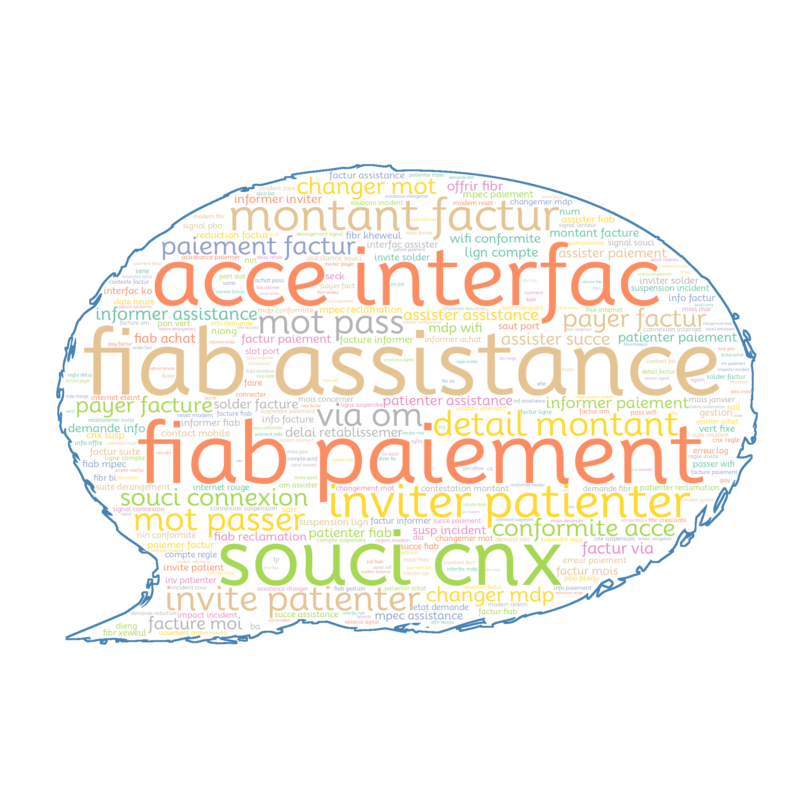

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np

# Charger le masque personnalisé (l'image doit être en noir et blanc)
mask = np.array(Image.open("/content/comment.png"))

# Charger les données à partir du fichier Excel
excel_file = "/content/preprocessedFixeData.xlsx"  # Remplacez par le chemin de votre fichier Excel
df = pd.read_excel(excel_file)


# Concaténer toutes les descriptions en une seule chaîne
text = ' '.join(df["Description_x"].astype(str))

# Créer un nuage de mots
wc = WordCloud(
        background_color="white",
        max_words=300,
        contour_width=3,
        mask=mask,
        contour_color='steelblue',
        colormap="Set2",
        prefer_horizontal=1,
        font_path="/content/Mooli-Regular.ttf",  # Remplacez par le chemin de votre police
)

# Générer le nuage de mots
wc.generate(text)
wc.to_file("nuage_de_mots_fixe.png")

# Afficher le nuage de mots
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
import pandas as pd
from gensim import corpora
import gensim
from gensim.models import LdaModel
import multiprocessing

# Define the path to the saved Excel file
# input_file_path = "C:/Users/Hp Laptop/Desktop/Stages_Sonatel/NLP_basic_tasks/LDA_Topic_Modeling/data/preprocessedData3.xlsx"

# Load the preprocessed DataFrame from the Excel file
# dataset = pd.read_excel(input_file_path)

# Tokenize the text in the 'crm_remonte_client.description_x' column
text_data = [str(text).split() for text in df['Description_x']]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

## Entrainement du modèle LDA

In [ ]:
from gensim.models import CoherenceModel
n = 10
ldaModel3 = gensim.models.LdaMulticore(
    corpus,
    num_topics=n,
    id2word=dictionary,
    random_state=100 ,
    passes=50,
    workers=multiprocessing.cpu_count()
)
topics = ldaModel3.print_topics(num_words=10)
for topic in topics:
    print(str(topic) + "\n")

coherence_model_lda = CoherenceModel(model=ldaModel3, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(0, '0.064*"assistance" + 0.035*"cnx" + 0.033*"modem" + 0.030*"connexion" + 0.029*"port" + 0.027*"incident" + 0.026*"souci" + 0.025*"internet" + 0.017*"fiab" + 0.015*"vert"')

(1, '0.179*"paiement" + 0.094*"factur" + 0.049*"om" + 0.047*"payer" + 0.040*"montant" + 0.040*"fiab" + 0.033*"facture" + 0.031*"detail" + 0.030*"info" + 0.030*"via"')

(2, '0.102*"paiement" + 0.037*"regle" + 0.032*"compte" + 0.031*"suspendre" + 0.030*"inviter" + 0.029*"invite" + 0.027*"delai" + 0.025*"patienter" + 0.025*"facture" + 0.025*"souci"')

(3, '0.077*"pass" + 0.050*"assistance" + 0.031*"box" + 0.024*"souci" + 0.015*"reception" + 0.015*"zsmart" + 0.015*"fixe" + 0.014*"credit" + 0.014*"positionner" + 0.013*"dossier"')

(4, '0.065*"mois" + 0.054*"reclamation" + 0.050*"factur" + 0.041*"montant" + 0.035*"facture" + 0.034*"erreur" + 0.027*"clt" + 0.025*"date" + 0.020*"contestation" + 0.019*"conteste"')

(5, '0.092*"achat" + 0.056*"demande" + 0.050*"fibr" + 0.039*"info" + 0.033*"offrir" + 0.028*"etat" + 0.019*"

In [ ]:
topics = ldaModel3.print_topics(num_words=20)
for topic in topics:
    print(str(topic) + "\n")

(0, '0.064*"assistance" + 0.035*"cnx" + 0.033*"modem" + 0.030*"connexion" + 0.029*"port" + 0.027*"incident" + 0.026*"souci" + 0.025*"internet" + 0.017*"fiab" + 0.015*"vert" + 0.015*"signal" + 0.014*"susp" + 0.013*"suspension" + 0.013*"rb" + 0.012*"pon" + 0.012*"eteint" + 0.011*"ko" + 0.011*"wifi" + 0.011*"actif" + 0.010*"rouge"')

(1, '0.179*"paiement" + 0.094*"factur" + 0.049*"om" + 0.047*"payer" + 0.040*"montant" + 0.040*"fiab" + 0.033*"facture" + 0.031*"detail" + 0.030*"info" + 0.030*"via" + 0.026*"informer" + 0.013*"fact" + 0.013*"assister" + 0.012*"paiemer" + 0.011*"demande" + 0.006*"informe" + 0.005*"appeler" + 0.005*"degrevement" + 0.004*"echeance" + 0.004*"pay"')

(2, '0.102*"paiement" + 0.037*"regle" + 0.032*"compte" + 0.031*"suspendre" + 0.030*"inviter" + 0.029*"invite" + 0.027*"delai" + 0.025*"patienter" + 0.025*"facture" + 0.025*"souci" + 0.024*"solder" + 0.024*"suspension" + 0.023*"cnx" + 0.022*"fiab" + 0.022*"lign" + 0.020*"retablissemer" + 0.019*"susp" + 0.019*"connexion

In [ ]:
from gensim.models import CoherenceModel
n = 12
ldaModel = gensim.models.LdaMulticore(
    corpus,
    num_topics=n,
    id2word=dictionary,
    random_state=100 ,
    passes=50,
    workers=multiprocessing.cpu_count()
)
topics = ldaModel.print_topics(num_words=20)
for topic in topics:
    print(str(topic) + "\n")

coherence_model_lda = CoherenceModel(model=ldaModel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(0, '0.076*"assistance" + 0.048*"cnx" + 0.039*"modem" + 0.031*"signal" + 0.030*"souci" + 0.028*"wifi" + 0.021*"lenteur" + 0.019*"connexion" + 0.017*"incident" + 0.017*"fiab" + 0.012*"voir" + 0.011*"ko" + 0.011*"debit" + 0.011*"susp" + 0.011*"cabl" + 0.010*"invite" + 0.010*"assister" + 0.010*"navigation" + 0.009*"allumer" + 0.008*"conx"')

(1, '0.187*"paiement" + 0.097*"factur" + 0.052*"om" + 0.048*"payer" + 0.041*"fiab" + 0.041*"montant" + 0.036*"facture" + 0.033*"detail" + 0.032*"via" + 0.032*"info" + 0.028*"informer" + 0.013*"assister" + 0.013*"paiemer" + 0.010*"demande" + 0.006*"informe" + 0.005*"appeler" + 0.005*"echeance" + 0.005*"information" + 0.004*"mpec" + 0.004*"pay"')

(2, '0.106*"paiement" + 0.037*"regle" + 0.033*"inviter" + 0.032*"compte" + 0.031*"suspendre" + 0.029*"invite" + 0.027*"delai" + 0.025*"facture" + 0.025*"fact" + 0.025*"patienter" + 0.024*"solder" + 0.023*"fiab" + 0.022*"souci" + 0.022*"suspension" + 0.022*"cnx" + 0.021*"lign" + 0.020*"retablissemer" + 0.019*"l

In [ ]:
def calculate_coherence_score(n):
    lda_model = gensim.models.LdaMulticore(
      corpus,
      num_topics=n,
      # alpha=alpha,
      # eta= beta,
      id2word=dictionary,
      random_state=100 ,
      passes=50,
      workers=multiprocessing.cpu_count()
    )
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=text_data,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Listes de différentes valeurs pour les hyperparamètres
no_of_topics = [10,11, 12,13, 14,15,16,17,18,19]

# Boucle pour tester différentes combinaisons d'hyperparamètres
for n in no_of_topics:
    coherence_score = calculate_coherence_score(n)
    print(f"n : {n} ; Score : {coherence_score}")

n : 10 ; Score : 0.6265236174550426
n : 11 ; Score : 0.5888497906779094
n : 12 ; Score : 0.614388536256004
n : 13 ; Score : 0.5631559594994001
n : 14 ; Score : 0.5426186226349394
n : 15 ; Score : 0.5394938033832565
n : 16 ; Score : 0.6074400821176367
n : 17 ; Score : 0.5556473638585091
n : 18 ; Score : 0.5478589072027793
n : 19 ; Score : 0.549142544343924


In [ ]:
def calculate_coherence_score(n,alpha,beta):
    lda_model = gensim.models.LdaMulticore(
      corpus,
      num_topics=n,
      alpha=alpha,
      eta= beta,
      id2word=dictionary,
      random_state=100 ,
      passes=50,
      workers=multiprocessing.cpu_count()
    )
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=text_data,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Listes de différentes valeurs pour les hyperparamètres
no_of_topics = [10,11, 12,13, 14,15,16,17,18,19]
alpha_list = ['symmetric', 0.3, 0.5, 0.7]
beta_list = ['auto', 0.3, 0.5, 0.7]

for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

n : 10 ; alpha : symmetric ; beta : auto ; Score : 0.6161620592611408
n : 10 ; alpha : symmetric ; beta : 0.3 ; Score : 0.6101836646340361
n : 10 ; alpha : symmetric ; beta : 0.5 ; Score : 0.6020067992346633
n : 10 ; alpha : symmetric ; beta : 0.7 ; Score : 0.5724458776579848
n : 10 ; alpha : 0.3 ; beta : auto ; Score : 0.5849121557905657
n : 10 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.6221107831182422
n : 10 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.6463190862464946
n : 10 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6363124990907308
n : 10 ; alpha : 0.5 ; beta : auto ; Score : 0.6070674200341429
n : 10 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.610565161418348
n : 10 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.6251670652573318
n : 10 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.6207935072237256


In [ ]:
# n : 10 ; alpha : symmetric ; beta : auto ; Score : 0.6161620592611408
# n : 10 ; alpha : symmetric ; beta : 0.3 ; Score : 0.6101836646340361
# n : 10 ; alpha : symmetric ; beta : 0.5 ; Score : 0.6020067992346633
# n : 10 ; alpha : symmetric ; beta : 0.7 ; Score : 0.5724458776579848
# n : 10 ; alpha : 0.3 ; beta : auto ; Score : 0.5849121557905657
# n : 10 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.6221107831182422
# n : 10 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.6463190862464946
# n : 10 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6363124990907308
# n : 10 ; alpha : 0.5 ; beta : auto ; Score : 0.6070674200341429
# n : 10 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.610565161418348
# n : 10 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.6251670652573318
# n : 10 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.6207935072237256

In [5]:
import pandas as pd
from gensim import corpora
import gensim
from gensim.models import LdaModel
import multiprocessing

# Define the path to the saved Excel file
input_file_path = "/content/preprocessedFixeData.xlsx"

# Load the preprocessed DataFrame from the Excel file
dataset = pd.read_excel(input_file_path)

# Tokenize the text in the 'crm_remonte_client.description_x' column
text_data = [str(text).split() for text in dataset['Description_x']]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# n : 10 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.6463190862464946
from gensim.models import CoherenceModel
n = 10
alpha = 0.3
beta = 0.5
# lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
lda_Model = gensim.models.LdaMulticore(
    corpus,
    num_topics=n,
    alpha=alpha,
    eta= beta,
    id2word=dictionary,
    random_state=100 ,
    passes=50,
    workers=multiprocessing.cpu_count()
)
topics = lda_Model.print_topics(num_words=20)
for topic in topics:
    print(str(topic) + "\n")

coherence_model_lda = CoherenceModel(model=lda_Model, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(0, '0.059*"assistance" + 0.034*"cnx" + 0.031*"modem" + 0.029*"connexion" + 0.025*"port" + 0.024*"internet" + 0.023*"souci" + 0.023*"incident" + 0.015*"fiab" + 0.014*"signal" + 0.014*"vert" + 0.012*"susp" + 0.011*"rb" + 0.011*"wifi" + 0.011*"pon" + 0.011*"suspension" + 0.010*"eteint" + 0.010*"ko" + 0.009*"rouge" + 0.009*"fixe"')

(1, '0.178*"paiement" + 0.090*"factur" + 0.059*"payer" + 0.043*"om" + 0.036*"fiab" + 0.034*"facture" + 0.033*"montant" + 0.027*"via" + 0.027*"detail" + 0.026*"info" + 0.025*"informer" + 0.014*"fact" + 0.011*"paiemer" + 0.010*"assister" + 0.006*"informe" + 0.005*"echeance" + 0.005*"appeler" + 0.004*"information" + 0.004*"payement" + 0.003*"mpec"')

(2, '0.072*"paiement" + 0.054*"inviter" + 0.036*"regle" + 0.036*"patienter" + 0.033*"compte" + 0.028*"suspendre" + 0.028*"delai" + 0.024*"suspension" + 0.024*"souci" + 0.022*"solder" + 0.022*"lign" + 0.022*"cnx" + 0.020*"fiab" + 0.020*"susp" + 0.020*"invite" + 0.020*"connexion" + 0.019*"facture" + 0.018*"retablisseme

In [ ]:
def calculate_coherence_score(n):
    lda_model = gensim.models.LdaMulticore(
      corpus,
      num_topics=n,
      # alpha=alpha,
      # eta= beta,
      id2word=dictionary,
      random_state=100 ,
      passes=50,
      workers=multiprocessing.cpu_count()
    )
    coherence_model_lda = CoherenceModel(
        model=lda_model,
        texts=text_data,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

no_of_topics = [7,8,6,11, 12]
for n in no_of_topics:
    coherence_score = calculate_coherence_score(n)
    print(f"n : {n} ; Score : {coherence_score}")

n : 7 ; Score : 0.5934410071205111
n : 8 ; Score : 0.6113805649780248
n : 6 ; Score : 0.5991382542572362
n : 11 ; Score : 0.5809885408484313
n : 12 ; Score : 0.6199902538765741


In [3]:
# n : 10 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.6463190862464946
from gensim.models import CoherenceModel
n = 10
alpha = 0.3
beta = 0.5
# lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
lda_Model = gensim.models.LdaMulticore(
    corpus,
    num_topics=n,
    alpha=alpha,
    eta= beta,
    id2word=dictionary,
    random_state=100 ,
    passes=50,
    workers=multiprocessing.cpu_count()
)
topics = lda_Model.print_topics(num_words=20)
for topic in topics:
    print(str(topic) + "\n")

coherence_model_lda = CoherenceModel(model=lda_Model, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(0, '0.058*"assistance" + 0.031*"cnx" + 0.030*"modem" + 0.028*"connexion" + 0.026*"port" + 0.025*"internet" + 0.024*"incident" + 0.022*"souci" + 0.015*"fiab" + 0.014*"vert" + 0.013*"signal" + 0.013*"susp" + 0.011*"suspension" + 0.011*"rb" + 0.011*"pon" + 0.011*"eteint" + 0.010*"wifi" + 0.010*"ko" + 0.010*"rouge" + 0.009*"fixe"')

(1, '0.172*"paiement" + 0.094*"factur" + 0.057*"payer" + 0.041*"om" + 0.036*"fiab" + 0.035*"montant" + 0.034*"facture" + 0.026*"via" + 0.026*"detail" + 0.025*"informer" + 0.024*"info" + 0.015*"fact" + 0.010*"paiemer" + 0.010*"pay" + 0.010*"assister" + 0.005*"informe" + 0.005*"echeance" + 0.005*"appeler" + 0.004*"payement" + 0.004*"mpec"')

(2, '0.067*"paiement" + 0.052*"inviter" + 0.050*"patienter" + 0.047*"invite" + 0.034*"regle" + 0.031*"compte" + 0.028*"delai" + 0.027*"suspendre" + 0.025*"suspension" + 0.023*"souci" + 0.021*"solder" + 0.021*"cnx" + 0.020*"lign" + 0.019*"susp" + 0.019*"connexion" + 0.019*"fiab" + 0.019*"facture" + 0.019*"ligne" + 0.018*"reta

In [8]:
from gensim.models import CoherenceModel
topics = lda_model.print_topics(num_words=20)
for topic in topics:
    print(str(topic) + "\n")

coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.058*"assistance" + 0.031*"cnx" + 0.030*"modem" + 0.028*"connexion" + 0.026*"port" + 0.025*"internet" + 0.024*"incident" + 0.022*"souci" + 0.015*"fiab" + 0.014*"vert" + 0.013*"signal" + 0.013*"susp" + 0.011*"suspension" + 0.011*"rb" + 0.011*"pon" + 0.011*"eteint" + 0.010*"wifi" + 0.010*"ko" + 0.010*"rouge" + 0.009*"fixe"')

(1, '0.172*"paiement" + 0.094*"factur" + 0.057*"payer" + 0.041*"om" + 0.036*"fiab" + 0.035*"montant" + 0.034*"facture" + 0.026*"via" + 0.026*"detail" + 0.025*"informer" + 0.024*"info" + 0.015*"fact" + 0.010*"paiemer" + 0.010*"pay" + 0.010*"assister" + 0.005*"informe" + 0.005*"echeance" + 0.005*"appeler" + 0.004*"payement" + 0.004*"mpec"')

(2, '0.067*"paiement" + 0.052*"inviter" + 0.050*"patienter" + 0.047*"invite" + 0.034*"regle" + 0.031*"compte" + 0.028*"delai" + 0.027*"suspendre" + 0.025*"suspension" + 0.023*"souci" + 0.021*"solder" + 0.021*"cnx" + 0.020*"lign" + 0.019*"susp" + 0.019*"connexion" + 0.019*"fiab" + 0.019*"facture" + 0.019*"ligne" + 0.018*"reta

In [7]:
perplexite = lda_model.log_perplexity(loaded_corpus)
print("Perplexité du modèle LDA : {:.2f}".format(perplexite))

Perplexité du modèle LDA : -6.49


### Modèle choisi : cohérence : 0.6349, Perplexité : -6.49
---

## Visualisation avec  pyLDAvis

In [5]:
import pyLDAvis
import pyLDAvis.gensim_models

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [6]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model,loaded_corpus,loaded_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.226637  0.006447       1        1  15.446367
7     -0.149638  0.097638       2        1  13.700908
2     -0.050023 -0.213879       3        1  12.126805
1      0.131694 -0.218728       4        1  11.596460
5      0.082070 -0.048664       5        1  10.893725
4      0.239503  0.046204       6        1   9.588857
9      0.134880  0.206058       7        1   7.491338
8     -0.135486 -0.026942       8        1   7.107365
3     -0.104246  0.088759       9        1   6.800855
6      0.077883  0.063108      10        1   5.247321, topic_info=            Term          Freq         Total Category  logprob  loglift
3       paiement  11541.000000  11541.000000  Default  30.0000  30.0000
5     assistance  11408.000000  11408.000000  Default  29.0000  29.0000
22        factur   7088.000000   7088.000000  Default  28.0000  28.0000
170     incident   4112.000000   4112.000000  Default  27.0000  27.0000
57         achat   3594.000000   3594.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
16        signal    308.947721   2655.902422  Topic10  -4.2429   0.7961
1266        drgt    111.566084    290.522253  Topic10  -5.2614   1.9904
71          mpec    189.702440   1903.093746  Topic10  -4.7306   0.6417
12          fiab    242.904697   6515.301931  Topic10  -4.4834  -0.3418
307        deler    123.276055    504.758286  Topic10  -5.1616   1.5378

[548 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
760       1  0.005744      ab
760       2  0.005744      ab
760       8  0.005744      ab
760      10  0.976475      ab
925       1  0.010002     abo
...     ...       ...     ...
870       9  0.647878  zsmart
1159      1  0.002884     zte
1159      2  0.989322     zte
1620      1  0.012054    zxhn
1620      2  0.952300    zxhn

[1497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 3, 2, 6, 5, 10, 9, 4, 7])

In [4]:
from gensim.models.ldamodel import LdaModel

# Load the model from a file
lda_model = LdaModel.load("/content/FixeLDAModel")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred